# PW05 - Group 4
* Florian Bär
* Matthias Egli
* Manuel Vogel
* Adrian Willi

In [35]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

### Loading Data

In [6]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

0.2%

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw


100.6%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw




4.6%

100.0%
119.3%

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [7]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [8]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### MLP


In [9]:
def mlp(units = [28*28,250,80,10]):
    seq = [torch.nn.Flatten()]
    for i in range(len(units)-2):
        seq.append(torch.nn.Linear(units[i],units[i+1]))
        seq.append(torch.nn.Sigmoid())
    seq.append(torch.nn.Linear(units[-2],units[-1]))
    return torch.nn.Sequential(*seq)

In [10]:
model = mlp()
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 250]         196,250
           Sigmoid-3                  [-1, 250]               0
            Linear-4                   [-1, 80]          20,080
           Sigmoid-5                   [-1, 80]               0
            Linear-6                   [-1, 10]             810
Total params: 217,140
Trainable params: 217,140
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


### Training

Implement the training / evaluation loop

Remember training / validation cost and accuracy per epoch. 

In [11]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None):
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in range(nepochs):
        model.train()
        size = len(training_loader.dataset)
        nbatches = len(training_loader)
        size_test = len(test_loader.dataset)
        nbatches_test = len(test_loader)
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

            # gradient, parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()
        cost /= nbatches
        acc /= size
    
        model.eval()
        cost_test, acc_test = 0.0, 0.0        
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                cost_test += cost_ce(pred, Y).item()
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        cost_test /= nbatches_test
        acc_test /= size_test
        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. SGD: Revisit plain SGD (without momentum) and try different learning rates (lr). Create suitable comparison plots (learning curves with the train and validate cost and accuracy) for (~3) different learning rates. Describe in words what you see. What is a reasonable number of epochs (nepochs)? What is your recommended best choice (lr, nepochs) for the given problem?

2. Momentum: Play with different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?

3. RMSprop: Same thing now for RMSprop (without momentum). Play with different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?

4. Adam: Same thing now for Adam. Play with different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?

5. Learning rate schedule: Implement a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task? Note the way how the scheduler is incorporated into the `train_eval`-method above.


### Plots and Comments (for the different steps described above) 

#### 1.  SDG

Revisit plain SGD (without momentum) and try different learning rates (lr). Create suitable comparison plots (learning curves with the train and validate cost and accuracy) for (~3) different learning rates. Describe in words what you see. What is a reasonable number of epochs (nepochs)? What is your recommended best choice (lr, nepochs) for the given problem?

In [24]:
nbatch = 64
nepochs = [30, 20, 10, 0.05]
lr = [0.1, 0.4, 0.8, 50]
    
costs_train = []
costs_test = []

for i in range(len(ls)):
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, 
                                                                    optimizer, 
                                                                    nepochs[i], 
                                                                    training_loader, 
                                                                    validation_loader)
    costs_train.append(cost_hist)
    costs_test.append(cost_hist_test)
    print("*"*100)

Epoch 0: 1.780234, 0.362340, 1.098353, 0.584200
Epoch 1: 0.902400, 0.664980, 0.777371, 0.710500
Epoch 2: 0.692131, 0.741200, 0.653432, 0.754600
Epoch 3: 0.603908, 0.774680, 0.593283, 0.782400
Epoch 4: 0.555308, 0.798200, 0.569759, 0.794000
Epoch 5: 0.522152, 0.813660, 0.536721, 0.807900
Epoch 6: 0.496889, 0.822920, 0.506440, 0.817400
Epoch 7: 0.476601, 0.829640, 0.504708, 0.821500
Epoch 8: 0.459659, 0.836600, 0.521589, 0.810200
Epoch 9: 0.446461, 0.840280, 0.502020, 0.815700
Epoch 10: 0.432893, 0.844900, 0.480184, 0.828600
Epoch 11: 0.423395, 0.849000, 0.460536, 0.828900
Epoch 12: 0.414481, 0.851860, 0.431375, 0.846100
Epoch 13: 0.407170, 0.854300, 0.584329, 0.787900
Epoch 14: 0.400339, 0.856540, 0.437580, 0.844200
Epoch 15: 0.393928, 0.859880, 0.449087, 0.840100
Epoch 16: 0.388736, 0.860440, 0.653000, 0.748100
Epoch 17: 0.382364, 0.862180, 0.450039, 0.842400
Epoch 18: 0.377135, 0.864600, 0.417556, 0.852700
Epoch 19: 0.371712, 0.866680, 0.408963, 0.855800
Epoch 20: 0.367547, 0.867460, 

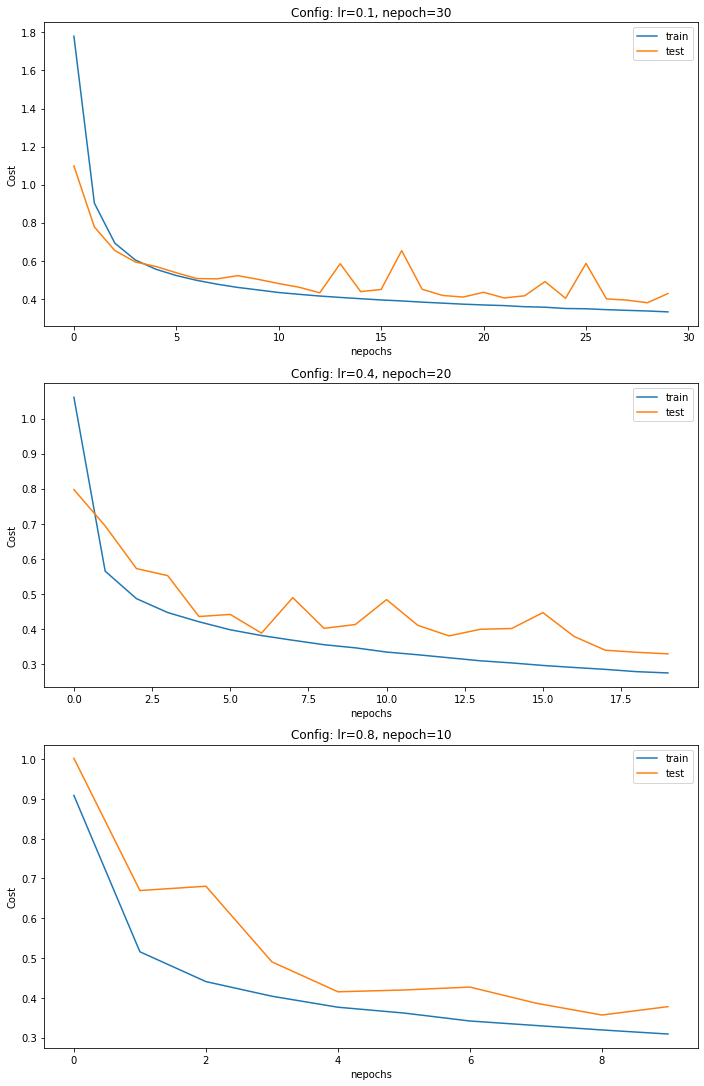

In [41]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,15)

for i in range(len(lr)):
    idx = 311 + i
    plt.subplot(idx)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train[i], label="train")
    plt.plot(torch.arange(nepochs[i]), costs_test[i], label="test")
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}")
    plt.xlabel("nepochs")
    plt.ylabel("Cost")
    plt.legend()

Results:


| nepochs | lr | Costs (Train) | Costs (Test) |
| :-: | :-: | :-: | :-: |
| 30 | 0.1 | 33.11% | 42.75% |
| **20** | **0.4** | **27.46%** | **32.90%** |
| 10 | 0.8 | 30.90% | 37.78% |d

Based on the performed experiments, the model trained for 20 epochs and with a learning rate of 0.4 performs the best on the Test set. However, the plot of the test cost is rather unsteady and not that smooth. 

#### 2.  Momentum
Play with different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?

In [46]:
nbatch = 64
nepochs = [30, 20, 10, 20, 20]
lr = [0.1, 0.4, 0.8, 0.4, 0.4]
m = [0.9, 0.8, 0.95, 1.1, 0.8]
nesterov = [False, False, False, False, True]
    
costs_train = []
costs_test = []

for i in range(len(lr)):
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr[i], momentum=m[i], nesterov=nesterov[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, 
                                                                    optimizer, 
                                                                    nepochs[i], 
                                                                    training_loader, 
                                                                    validation_loader)
    costs_train.append(cost_hist)
    costs_test.append(cost_hist_test)
    print("*"*100)

Epoch 0: 0.826951, 0.685600, 0.523093, 0.808500
Epoch 1: 0.466655, 0.830580, 0.464996, 0.832700
Epoch 2: 0.415761, 0.848380, 0.460619, 0.836300
Epoch 3: 0.384917, 0.859080, 0.407043, 0.851700
Epoch 4: 0.361675, 0.866660, 0.363322, 0.868000
Epoch 5: 0.342184, 0.874500, 0.377882, 0.861700
Epoch 6: 0.330529, 0.876340, 0.346621, 0.873400
Epoch 7: 0.312578, 0.883980, 0.362312, 0.862900
Epoch 8: 0.302017, 0.887500, 0.344856, 0.874200
Epoch 9: 0.293019, 0.890800, 0.357271, 0.875500
Epoch 10: 0.286144, 0.892800, 0.341102, 0.875900
Epoch 11: 0.273708, 0.897260, 0.375516, 0.868500
Epoch 12: 0.270233, 0.897840, 0.321987, 0.883600
Epoch 13: 0.261600, 0.902280, 0.333907, 0.881700
Epoch 14: 0.252160, 0.905780, 0.334514, 0.879000
Epoch 15: 0.247863, 0.906020, 0.330662, 0.877300
Epoch 16: 0.241453, 0.908980, 0.358399, 0.874900
Epoch 17: 0.235620, 0.912240, 0.316993, 0.890500
Epoch 18: 0.229335, 0.913880, 0.341540, 0.881000
Epoch 19: 0.225350, 0.914380, 0.347001, 0.876700
Epoch 20: 0.219035, 0.917940, 

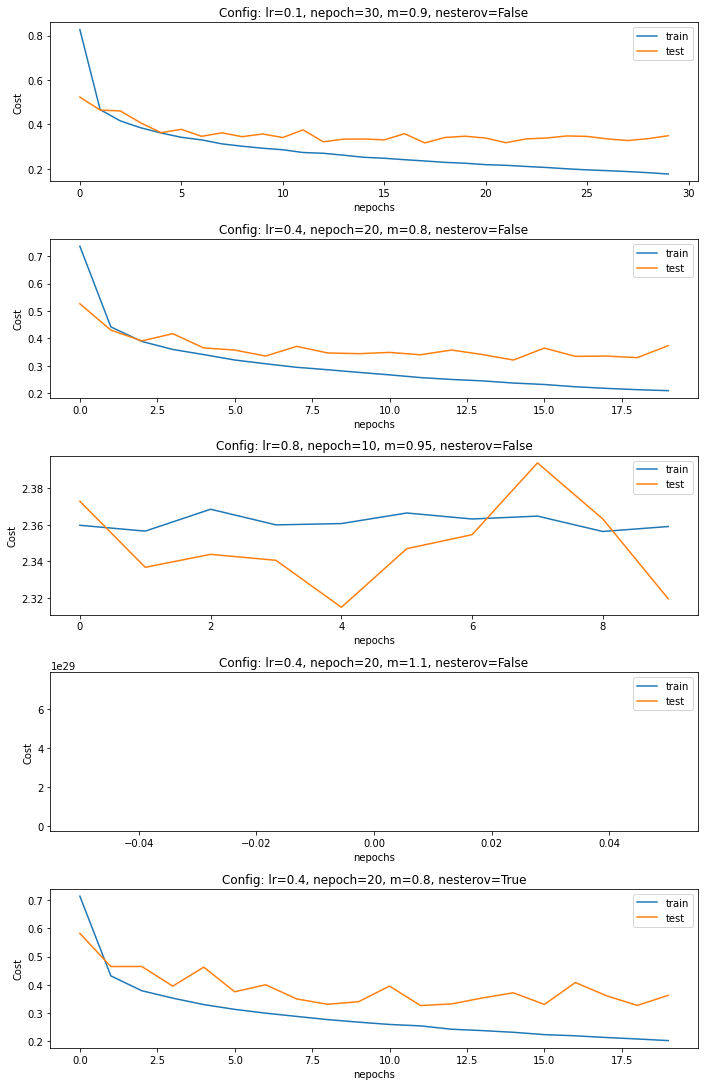

In [47]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,15)

for i in range(len(lr)):
    idx = 511 + i
    plt.subplot(idx)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train[i], label="train")
    plt.plot(torch.arange(nepochs[i]), costs_test[i], label="test")
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}, m={m[i]}, nesterov={nesterov[i]}")
    plt.xlabel("nepochs")
    plt.ylabel("Cost")
    plt.legend()

Results:


| nepochs | lr | momentum | nesterov |  Costs (Train) | Costs (Test) |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **30** | **0.1** | **0.9** | **False** | **17.68%** | **34.94%** |
| 20 | 0.4 | 0.8 | False | 21.00% | 37.38% |
| 10 | 0.8 | 0.95 | False | 235% | 235% |
| 20 | 0.4 | 1.1 | False | nan | nan |
| 20 | 0.4 | 0.8 | True | 20.32% | 36.33% |

The first model in the table achieves the best results on the training and the test data. The NaN in the fourth model is probably due to exceeding the definition area of the Momentum parameter. In general, the cost is slowly increasing over time. Therefore, further training with the chosen settings would be unsuitable. When comparing plot 2 and 5, setting the Nesterov parameter to true, lead to a slightly more fluctuating loss and a small improvement on both datasets.

#### 3.  RMSprop

Same thing now for RMSprop (without momentum). Play with different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?

In [51]:
nbatch = 64
nepochs = [30, 20, 10, 20, 20, 20, 20, 20]
lr = [0.01, 0.05, 0.1, 0.05, 0.4, 0.005, 0.005, 0.001]
alpha = [0.99, 0.9, 0.8, 0.9, 0.95, 0.98, 0.98, 0.98]
centered = [False, False, False, False, False, False, True, False]
    
costs_train = []
costs_test = []

for i in range(len(lr)):
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr[i], alpha=alpha[i],centered=centered[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, 
                                                                    optimizer, 
                                                                    nepochs[i], 
                                                                    training_loader, 
                                                                    validation_loader)
    costs_train.append(cost_hist)
    costs_test.append(cost_hist_test)
    print("*"*100)

Epoch 0: 0.843745, 0.686120, 0.712744, 0.701200
Epoch 1: 0.494540, 0.822100, 0.492079, 0.824200
Epoch 2: 0.448887, 0.839280, 0.485904, 0.822500
Epoch 3: 0.434831, 0.842620, 0.443790, 0.843200
Epoch 4: 0.408903, 0.851800, 0.434668, 0.844800
Epoch 5: 0.401826, 0.853980, 0.429260, 0.846000
Epoch 6: 0.390830, 0.859720, 0.447162, 0.841400
Epoch 7: 0.382214, 0.861640, 0.464129, 0.840900
Epoch 8: 0.380641, 0.861860, 0.457060, 0.850400
Epoch 9: 0.376179, 0.865140, 0.445877, 0.839800
Epoch 10: 0.375179, 0.865400, 0.475641, 0.833500
Epoch 11: 0.369780, 0.867700, 0.418165, 0.854100
Epoch 12: 0.370832, 0.865860, 0.476270, 0.839300
Epoch 13: 0.364252, 0.868460, 0.464867, 0.824700
Epoch 14: 0.361155, 0.868080, 0.412959, 0.851100
Epoch 15: 0.362716, 0.870400, 0.497479, 0.833800
Epoch 16: 0.360216, 0.872380, 0.573806, 0.803000
Epoch 17: 0.355712, 0.872080, 0.451107, 0.841700
Epoch 18: 0.354774, 0.872780, 0.433173, 0.846600
Epoch 19: 0.354363, 0.871900, 0.449180, 0.838300
Epoch 20: 0.348949, 0.874880, 

Epoch 14: 0.229298, 0.915040, 0.456554, 0.847100
Epoch 15: 0.222839, 0.918040, 0.403233, 0.862600
Epoch 16: 0.215548, 0.920060, 0.392867, 0.865700
Epoch 17: 0.208317, 0.922640, 0.356567, 0.878600
Epoch 18: 0.201990, 0.924740, 0.323344, 0.890800
Epoch 19: 0.195935, 0.927880, 0.324098, 0.892900
****************************************************************************************************


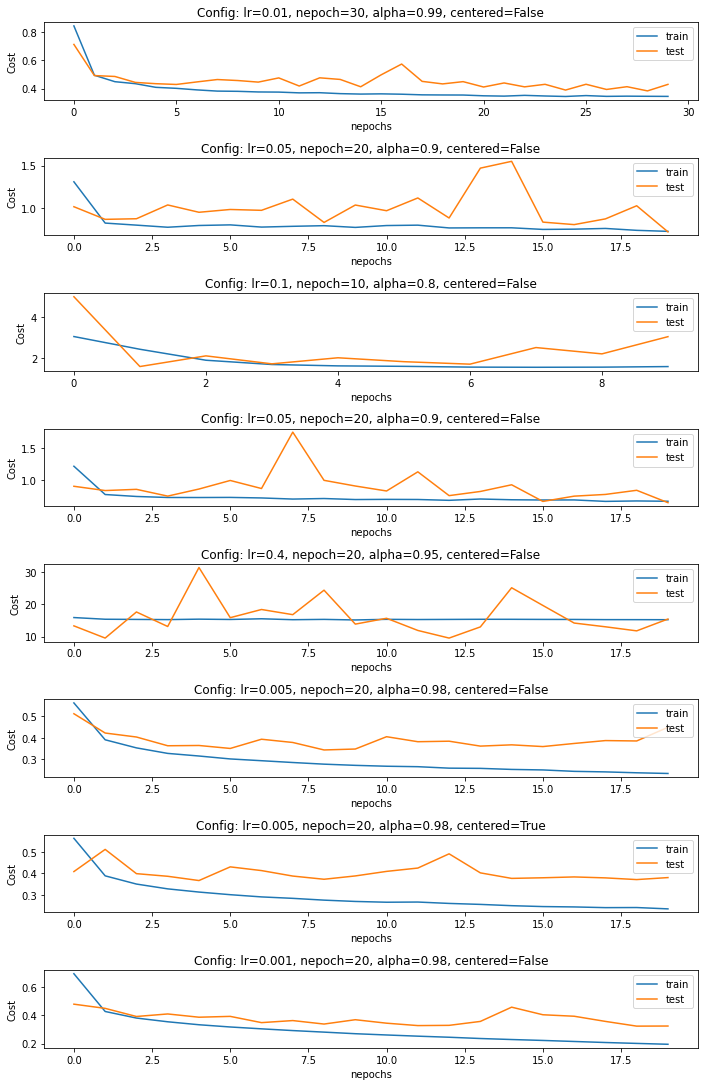

In [52]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,15)

for i in range(len(lr)):
    idx = 811 + i
    plt.subplot(idx)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train[i], label="train")
    plt.plot(torch.arange(nepochs[i]), costs_test[i], label="test")
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}, alpha={alpha[i]}, centered={centered[i]}")
    plt.xlabel("nepochs")
    plt.ylabel("Cost")
    plt.legend()

Results:


| nepochs | lr | alpha | centered |  Costs (Train) | Costs (Test) |
| :-: | :-: | :-: | :-: | :-: | :-: |
| 30 | 0.01 | 0.99 | False | 34.47% | 42.98% |
| 20 | 0.05 | 0.9 | False | 72.27% | 71.66% |
| 10 | 0.01 | 0.8 | False | 160% | 305% |
| 20 | 0.05 | 0.9 | False | 67.09% | 64.88% |
| 20 | 0.4 | 0.95 | False | 1522% | 1543% |
| 20 | 0.005 | 0.98 | False | 23.39% | 44.92% |
| 20 | 0.005 | 0.98 | True | 23.34% | 38.07% |
| **20** | **0.001** | **0.98** | **False** | **19.59%** | **32.40%** |

In this section, the best results are obtained when using the last setting. Generally, a learning rate below 0.001 seems to be superior. When using a bigger learning rate, the cost can increase drastically (e.g. model 5) and the model performs accordingly poor. If we set the parameter centered to true, the model can be further improved (e.g. compare model 6 and 7).

#### 4.  Adam
Same thing now for Adam. Play with different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?

In [56]:
nbatch = 64
nepochs = [20, 20, 20, 10, 20, 20]
lr = [0.001, 0.001, 0.005, 0.01, 0.0001, 0.0005]
betas = [(0.9, 0.999), (0.8, 0.95), (0.9, 0.9), (0.99, 0.9), (0.9, 0.999), (0.9, 0.999)]
    
costs_train = []
costs_test = []

for i in range(len(lr)):
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr[i], betas=betas[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, 
                                                                    optimizer, 
                                                                    nepochs[i], 
                                                                    training_loader, 
                                                                    validation_loader)
    costs_train.append(cost_hist)
    costs_test.append(cost_hist_test)
    print("*"*100)

Epoch 0: 0.779361, 0.740780, 0.473711, 0.833100
Epoch 1: 0.419421, 0.850020, 0.415881, 0.848400
Epoch 2: 0.371458, 0.866640, 0.377355, 0.863300
Epoch 3: 0.343749, 0.875280, 0.368816, 0.866100
Epoch 4: 0.324131, 0.882820, 0.348407, 0.875000
Epoch 5: 0.308091, 0.887660, 0.341034, 0.876800
Epoch 6: 0.293517, 0.892980, 0.334804, 0.880800
Epoch 7: 0.283066, 0.895760, 0.333133, 0.879000
Epoch 8: 0.272100, 0.899760, 0.330439, 0.883800
Epoch 9: 0.263254, 0.903720, 0.331927, 0.879100
Epoch 10: 0.253760, 0.905100, 0.321083, 0.883200
Epoch 11: 0.244282, 0.908660, 0.308264, 0.890400
Epoch 12: 0.233344, 0.912920, 0.316890, 0.887700
Epoch 13: 0.226676, 0.916320, 0.333175, 0.883800
Epoch 14: 0.219570, 0.918020, 0.315210, 0.888300
Epoch 15: 0.211877, 0.923780, 0.310375, 0.893900
Epoch 16: 0.203114, 0.925180, 0.322461, 0.888300
Epoch 17: 0.198524, 0.926060, 0.312915, 0.890100
Epoch 18: 0.190006, 0.929700, 0.318269, 0.893400
Epoch 19: 0.183106, 0.932300, 0.314730, 0.889700
******************************

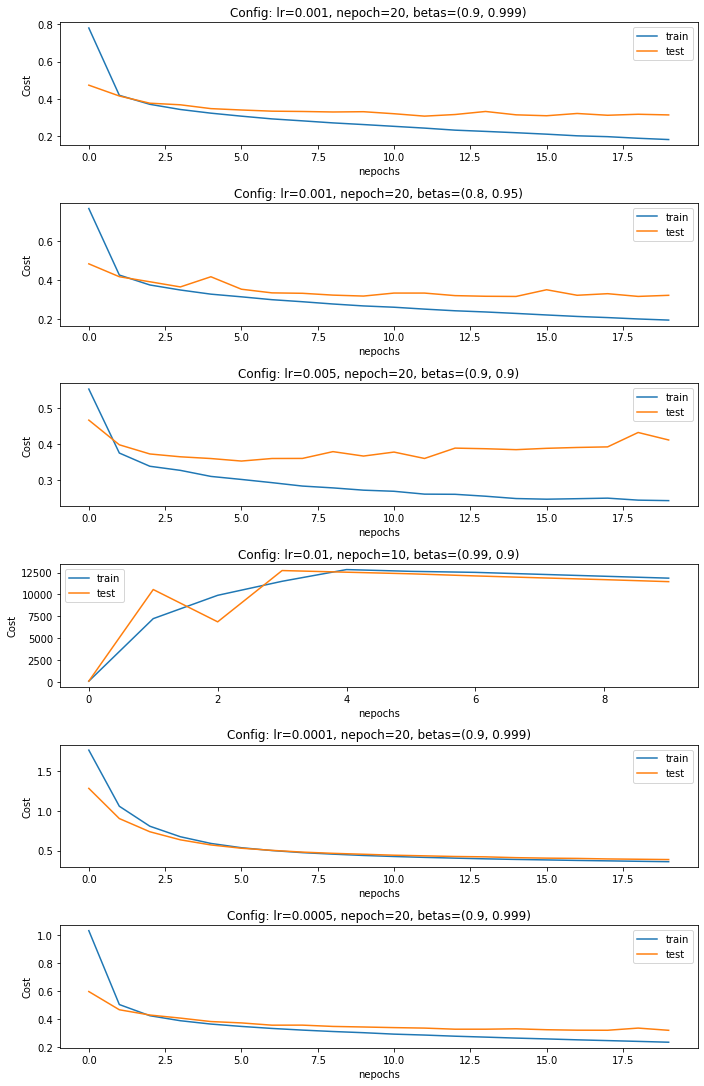

In [57]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,15)

for i in range(len(lr)):
    idx = 611 + i
    plt.subplot(idx)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train[i], label="train")
    plt.plot(torch.arange(nepochs[i]), costs_test[i], label="test")
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}, betas={betas[i]}")
    plt.xlabel("nepochs")
    plt.ylabel("Cost")
    plt.legend()

Results:


| nepochs | lr | betas |  Costs (Train) | Costs (Test) |
| :-: | :-: | :-: | :-: | :-: | 
| **20** | **0.001** | **(0.9, 0.999)** | **18.31%** | **31.47%** |
| 20 | 0.001 | (0.8, 0.95) | 19.55% | 32.24% |
| 20 | 0.005 | (0.9, 0.9) | 24.20% | 41.16% |
| 10 | 0.01 | (0.99, 0.9) | 1185609% | 1145552% |
| 20 | 0.0001 | (0.9, 0.999) | 35.96% | 38.66% |
| 20 | 0.0005 | (0.9, 0.999) | 23.27% | 31.81% |

Best setting is when we use the default parameter settings of pytorch and train the model for 20 epochs. Like in other experiments, increasing the learning rate worsens the outcome. Perhaps we could decrease our costs even more if we train the last model for a few epochs more. However, the increasing gap between train and test cost has to be watched closely.

#### 5.  LR schedule
Implement a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task? Note the way how the scheduler is incorporated into the `train_eval`-method above.

In [65]:
nbatch = 64
nepochs = [30, 20, 10, 20]
lr = [0.1, 0.4, 0.8, 0.4]
step_size = [30, 20, 50, 10]
gamma = [0.1, 0.01, 0.5, 0.1]

costs_train = []
costs_test = []

for i in range(len(lr)):
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr[i])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size[i], gamma[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, 
                                                                    optimizer, 
                                                                    nepochs[i], 
                                                                    training_loader, 
                                                                    validation_loader,
                                                                    scheduler)
    costs_train.append(cost_hist)
    costs_test.append(cost_hist_test)
    print("*"*100)

Epoch 0: 1.735243, 0.375600, 1.100882, 0.582700
Epoch 1: 0.919369, 0.654760, 0.820937, 0.668000
Epoch 2: 0.708347, 0.737600, 0.661920, 0.749900
Epoch 3: 0.607431, 0.773160, 0.611623, 0.772900
Epoch 4: 0.555416, 0.799540, 0.552225, 0.807300
Epoch 5: 0.519695, 0.815460, 0.536807, 0.807600
Epoch 6: 0.493171, 0.824860, 0.526369, 0.813500
Epoch 7: 0.473216, 0.831520, 0.515529, 0.818300
Epoch 8: 0.455964, 0.837320, 0.486901, 0.828500
Epoch 9: 0.443335, 0.841520, 0.500318, 0.821500
Epoch 10: 0.431853, 0.846300, 0.502196, 0.818700
Epoch 11: 0.422616, 0.848660, 0.456034, 0.831800
Epoch 12: 0.413546, 0.852540, 0.481929, 0.823500
Epoch 13: 0.405135, 0.855400, 0.467853, 0.830900
Epoch 14: 0.397869, 0.858680, 0.418717, 0.852900
Epoch 15: 0.391987, 0.859360, 0.436041, 0.842000
Epoch 16: 0.386435, 0.861960, 0.426678, 0.847100
Epoch 17: 0.380171, 0.863680, 0.440214, 0.834700
Epoch 18: 0.374072, 0.865180, 0.408693, 0.852700
Epoch 19: 0.369619, 0.867000, 0.410124, 0.856400
Epoch 20: 0.364961, 0.868960, 

Results:

| nepochs | lr | step_size | gamma | Costs (Train) | Costs (Test) |
| :-: | :-: | :-: | :-: | :-: | :-: |
| 30 | 0.01 | 30 | 0.1 | 32.97% | 37.18% |
| 20 | 0.04 | 20 | 0.01 | 27.65% | 36.99% |
| 10 | 0.08 | 50 | 0.5 | 31.00% | 39.21% |
| **20** | **0.04** | **10** | **0.1** | **30.14%** | **34.73%** |

We achieve the best model with a step_size of 10 and a gamme of 0.1. However, when comparing to the original SGD training and the same LR and nepochs, the results with the LRStep are ca. 4% worse.

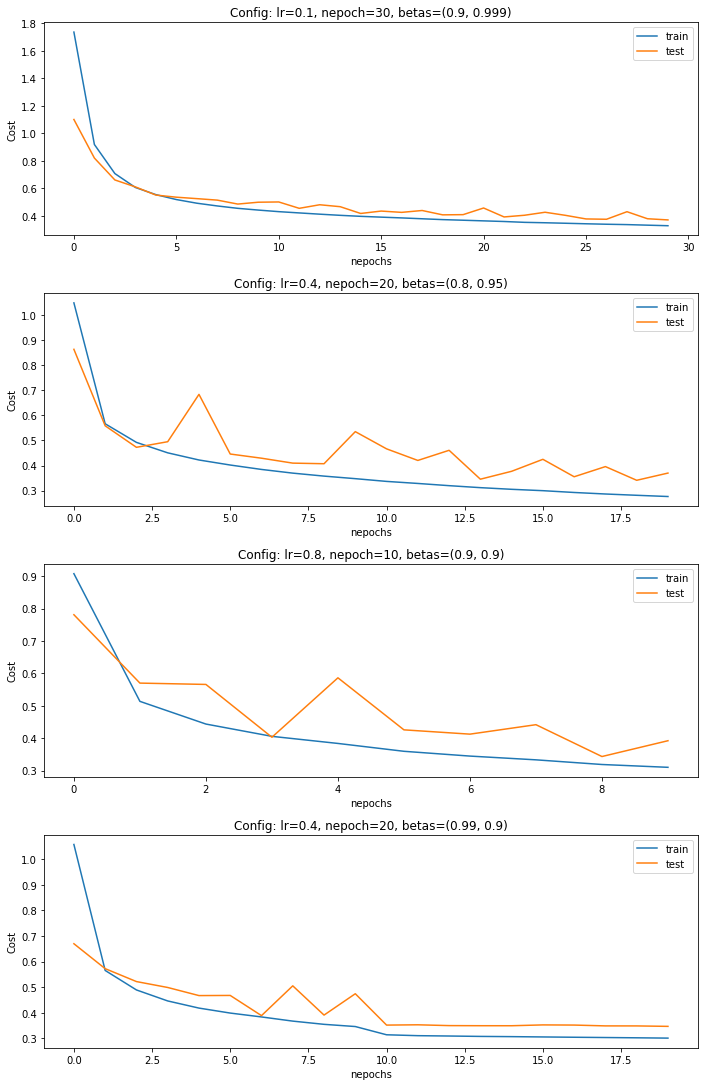

In [66]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,15)

for i in range(len(lr)):
    idx = 411 + i
    plt.subplot(idx)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train[i], label="train")
    plt.plot(torch.arange(nepochs[i]), costs_test[i], label="test")
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}, betas={betas[i]}")
    plt.xlabel("nepochs")
    plt.ylabel("Cost")
    plt.legend()